In [15]:
import sys
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np

import yfinance as yf
from fredapi import Fred

import matplotlib.pyplot as plt

In [128]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error

In [17]:
plot_ratio = pd.read_csv(os.path.join(os.environ['PYTHONPATH'],'yahoo','data','OVX_VIX_Ratio.csv'),index_col=0)
plot_ratio = plot_ratio.set_index('Date')
plot_ratio.index = pd.to_datetime(plot_ratio.index)
#plot_ratio = plot_ratio.loc[:,['Z_Score']]

plot_ratio = plot_ratio.loc[~plot_ratio['Z_Score'].isna(),:]
plot_ratio.index = plot_ratio.index.map(lambda x: pd.to_datetime(x).date())
plot_ratio.head()

,OVX,VIX,Ratio,Rolling30,Diff,Mean,STD,Z_Score,Max_1y_Z_Score,Min_1y_Z_Score
Date,,,,,,,,,,
2008-05-09,37.430000,19.410000,1.928387,1.881357,0.047030,1.558837,0.278349,1.327652,NaN,NaN
2008-05-12,37.549999,17.790001,2.110736,1.900537,0.210199,1.557401,0.278086,1.989799,NaN,NaN
2008-05-13,38.110001,17.980000,2.119577,1.912812,0.206765,1.559623,0.279768,2.001492,NaN,NaN
2008-05-14,36.799999,17.660000,2.083805,1.925422,0.158383,1.561687,0.281140,1.857147,NaN,NaN
2008-05-15,38.770000,16.299999,2.378528,1.946154,0.432374,1.563372,0.284725,2.862958,NaN,NaN


In [18]:
plot_ratio.shape

(4308, 10)

In [108]:
look_back_lag = 30

data = plot_ratio.loc[:,['Z_Score']]
for i in range(1,look_back_lag+1):
    data.loc[:,'Lag_'+str(i)] = data[['Z_Score']].shift(i)

data.tail(6).iloc[:,0:10]

,Z_Score,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9
Date,,,,,,,,,,
2025-06-17,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085,0.493445,-0.170514,0.514586
2025-06-18,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085,0.493445,-0.170514
2025-06-20,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085,0.493445
2025-06-23,1.790709,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005,0.158085
2025-06-24,1.983490,1.790709,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283,0.327005
2025-06-25,1.381541,1.983490,1.790709,2.885075,3.409998,3.489047,2.654744,2.134951,1.534491,1.513283


# Recursive strategy

In [148]:
train_data_n = 252*3
recursive_results = {}
horizon = 3 

#while train_data_n<data.shape[0]:
while train_data_n<252*3 + 300:
    # perform one fit 
    slice_df = data.head(train_data_n).copy()
    # at most use 5 years of data -> moving window 
    slice_df = slice_df.tail(5*252)
    y_train = slice_df.loc[:,'Z_Score'].values
    y_train = y_train.reshape(-1,1)
    x_train = slice_df.iloc[:,1:].values

    true_Y = data.loc[data.index>=max(slice_df.index),:].head(horizon).loc[:,['Z_Score']]
    true_Y.loc[:,'pred'] = np.nan

    # fit once 
    model = MultiOutputRegressor(XGBRegressor())
    model.fit(x_train, y_train)

    # predict next 3 days
    x_predict = slice_df.iloc[-1,0:look_back_lag].values.reshape(1,-1)
    y_predict = model.predict(x_predict)
    true_Y.iloc[0,1] = y_predict    
    for i in range(1,horizon):
        x_predict = np.concatenate((y_predict[0],x_predict[0][0:(look_back_lag-1)])).reshape(1,-1)
        y_predict = model.predict(x_predict)
        true_Y.iloc[i,1] = y_predict

    last_date_index = slice_df.index.max()
    recursive_results[last_date_index] = true_Y
    train_data_n += 1


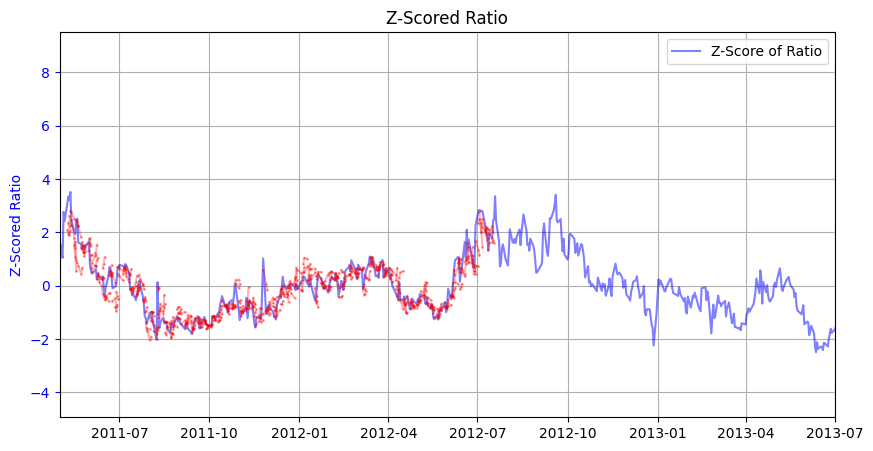

In [153]:
fig_h, ax = plt.subplots(figsize=(10,5))

p1, = ax.plot(plot_ratio.index,plot_ratio.Z_Score,color='b',marker=None,ms=2,
              alpha=0.5,label='Z-Score of Ratio')

for k,v in recursive_results.items():
    ax.plot(v.index,v.pred,'-',color='r',marker='.',ms=2,alpha=0.3)

ax.grid()
ax.set_ylabel('Z-Scored Ratio', color='b')
ax.tick_params('y', colors='b')
plt.legend()

plt.xlim([datetime.date(2011,5,1), datetime.date(2013,7,1)])

plt.title("Z-Scored Ratio")
plt.show()
plt.close()

In [150]:
rmse_df = []

for k,v in recursive_results.items():
    rmse_df.append([k, root_mean_squared_error(v.Z_Score,v.pred)])
rmse_df = pd.DataFrame(rmse_df,columns=['Date','RMSE'])
rmse_df = rmse_df.set_index('Date')
rmse_df.tail()

,RMSE
Date,
2012-07-10,0.290651
2012-07-11,0.496086
2012-07-12,0.224190
2012-07-13,0.360934
2012-07-16,0.671538


In [147]:
root_mean_squared_error(v.Z_Score,v.pred)

0.1041523676685025

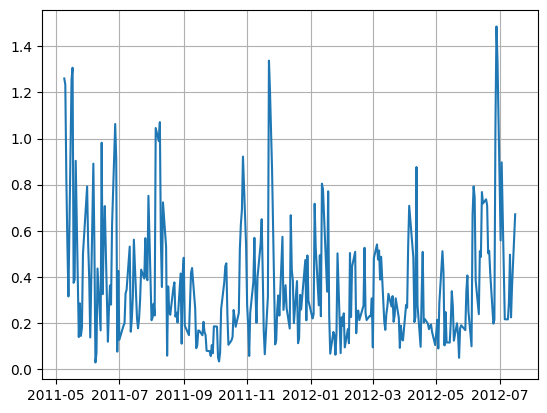

In [151]:
plt.figure()


plt.plot(rmse_df.index,rmse_df.RMSE)

plt.grid()
plt.show()